In [1]:
import os
import pickle
from functools import partial
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import spearmanr

root_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))
os.chdir(root_dir)

import functions

In [4]:
with open(root_dir + '/results/training_90_with_tag.pkl', 'rb') as handle:
    training = pickle.load(handle)

with open(root_dir + '/results/testing_90_with_tag.pkl', 'rb') as h:
    testing = pickle.load(h)

bs_samples = []
for i, v in enumerate(training):
    sample = []
    for i in range(1000): #1000 resample for each training cross validation step
        sol = v.loc[v['Solubility'] == 1].sample(1000, random_state=i)
        insol = v.loc[v['Solubility'] == 0].sample(1000, random_state=i)
        sample.append(sol.append(insol))
    bs_samples.append(sample)


In [6]:
def avr_arr(arr):
    tt = pd.DataFrame({'weights':arr})
    tt = pd.DataFrame(tt.weights.tolist(), columns=[k for k,v in flexibilities_smith.items()])
    return tt.mean().values


In [8]:
import multiprocessing
from multiprocessing import Pool
from sklearn.metrics import roc_curve, auc


#Initial 'guess' values
#Smith's flexibility used as initial weights had slightly greater
# AUC than Vihinen. So we use it as starting point in optimisation.
#Smith, David K., et al. 2003
flexibilities_smith = {'A': 0.717, 'C': 0.668, 'E': 0.963, 'D': 0.921,\
                         'G': 0.843, 'F': 0.599, 'I': 0.632, 'H': 0.754, \
                         'K': 0.912, 'M': 0.685, 'L': 0.681, 'N': 0.851,\
                         'Q': 0.849, 'P': 0.85, 'S': 0.84, 'R': 0.814, 'T': 0.758, \
                         'W': 0.626, 'V': 0.619, 'Y': 0.615}
init_state = [v for k, v in flexibilities_smith.items()]


optis_full = [] #full results of optimisation
weights_full_bs = []
aucs_train_full_bs = []

for i, v in enumerate(bs_samples):
    pools = Pool(multiprocessing.cpu_count())
    optis = [] #full results of optimisationp
    weights = []
    aucs_train = []
    cost_funcs = [partial(functions.cost_func, df=t) for t in v]
    optimiser = partial(optimize.minimize, x0=init_state, method="Nelder-Mead", \
                             options={ 'maxiter': 3000, 'maxfev': 3000,\
                           'disp': False, 'return_all': False,\
                           'xatol': 0.001, 'fatol': 0.0001, 'adaptive': True})
    
    for result in pools.map(optimiser, cost_funcs): #map is used for correct orders
        optis.append(result)
        aucs_train.append(-result['fun'])
        weights.append(result['x'])
    pools.close()
    pools.join()
    optis_full.append(optis)
    weights_full_bs.append(weights)
    aucs_train_full_bs.append(aucs_train)
    print(i)
    
    






In [9]:
cross_val_df = pd.DataFrame({'opti': optis_full, 'weights':weights_full_bs, \
                             'aucs_train_bs':aucs_train_full_bs})
cross_val_df['weight'] = cross_val_df['weights'].apply(avr_arr)
aucs_train = [-functions.cost_func(cross_val_df.weight[i], t) for i, t in enumerate(training)]
aucs_test = [-functions.cost_func(cross_val_df.weight[i], t) for i, t in enumerate(testing)]
cross_val_df['aucs_train'] = aucs_train
cross_val_df['aucs_test'] = aucs_test
cross_val_df.to_pickle(root_dir + '/results/cross_validation_90_with_histag.pkl.gz', compression='infer')

In [10]:
cross_val_df = pd.read_pickle(root_dir + '/results/cross_validation_90_with_histag.pkl.gz')


mean_std = pd.DataFrame(index=['Training', 'Test'])
mean_std.loc['Training', 'Mean'] = np.mean(cross_val_df['aucs_train'])
mean_std.loc['Training', 'Std'] = np.std(cross_val_df['aucs_train'])
mean_std.loc['Test', 'Mean'] = np.mean(cross_val_df['aucs_test'])
mean_std.loc['Test', 'Std'] = np.std(cross_val_df['aucs_test'])
mean_std


,Mean,Std
Training,0.718707,0.002054
Test,0.712893,0.018782


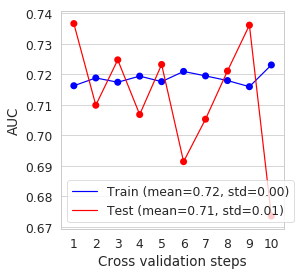

In [11]:

functions.plt.figure(figsize=(4, 4))
functions.sns.pointplot(list(range(10)), cross_val_df['aucs_train'], label='Train (mean=0.72, std=0.00)',\
                       linestyles=[' '], markers=['o'], color='blue')
functions.sns.lineplot(list(range(10)), cross_val_df['aucs_train'], label='Train (mean=0.72, std=0.00)',\
                       color='blue')
functions.sns.pointplot(list(range(10)), cross_val_df['aucs_test'],  label='Test (mean=0.71, std=0.01)',\
                        linestyles=[''], markers=['o'], color='red')
ax = functions.sns.lineplot(list(range(10)), cross_val_df['aucs_test'],  label='Test (mean=0.71, std=0.01)',\
                        color='red')
functions.plt.ylabel('AUC')
functions.plt.xlabel('Cross validation steps')

ax.set_xticklabels(list(range(1,11)))
functions.plt.savefig(root_dir + '/figs/cross_validation_90_with_histag.pdf')

In [12]:
SWI_cv = pd.DataFrame(cross_val_df['weight'].values.tolist(), columns=[k for k,v in flexibilities_smith.items()])
SWI_cv.mean()#.sort_values()

A    0.836092
C    0.521176
E    0.987117
D    0.907322
G    0.799174
F    0.583392
I    0.680159
H    0.896444
K    0.926668
M    0.629371
L    0.654099
N    0.859329
Q    0.790333
P    0.822390
S    0.743284
R    0.772006
T    0.808989
W    0.639605
V    0.735323
Y    0.611021
dtype: float64

### Compare the final SWI with initial weights and also hydrophobicity

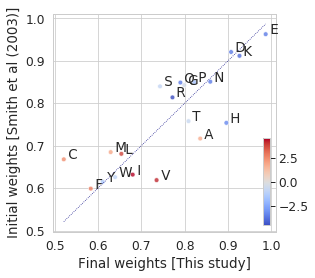

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#using hydrophobicity as hue# Kyte & Doolittle index of hydrophobicity
# J. Mol. Biol. 157:105-132(1982).
kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
      "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
      "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
      "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2}

df1 = pd.DataFrame(columns=SWI_cv.mean().index, \
                   index=['Initial weights [Smith et al. (2003)]', 'Final weights [This study]'])
df1.loc['Initial weights [Smith et al (2003)]'] = [v for k,v in flexibilities_smith.items()]
df1.loc['Final weights [This study]'] = SWI_cv.mean().values
df1 = df1.transpose()
for k, v in kd.items():
    df1.loc[k, 'Hydrophobicity'] = v
df1.reset_index(inplace=True)

functions.sns.set(style="whitegrid")
functions.sns.set_context("paper", font_scale=1.4)
functions.plt.figure(figsize=(4, 4))


norm = functions.plt.Normalize(df1['Hydrophobicity'].min(), df1['Hydrophobicity'].max())
sm = functions.plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])


y = 'Initial weights [Smith et al (2003)]'
x = 'Final weights [This study]'
g = functions.sns.scatterplot(x, y, data=df1, markers=False, hue=df1['Hydrophobicity'], \
                              palette="coolwarm", \
                             alpha=.8,  ) #relplot, height=6
functions.plt.plot([SWI_cv.mean().min(), SWI_cv.mean().max()], \
                   [SWI_cv.mean().min(), SWI_cv.mean().max()], color='navy', lw=.75, linestyle=':')
# functions.sns.despine()#color bar
g.get_legend().remove()
cbaxes = inset_axes(g, width="3%", height="40%", loc=4)
cb = g.figure.colorbar(sm, cax=cbaxes, orientation="vertical")

for i, v in enumerate(df1['index']):
    g.annotate(' ' +v, [df1[x][i], df1[y][i]])
functions.plt.savefig(root_dir + '/figs/weight_scatterplot_90_with_histag.pdf')

In [14]:
#SWI
cols = [k for k, v in flexibilities_smith.items()]
wdf = pd.DataFrame(columns=cols, index=list(range(10)))
weights = cross_val_df['weight'].values #weights from CV

for idx, val in enumerate(weights):
    for i, v in enumerate(val):
        wdf.loc[idx][cols[i]] = v

new_wts = {} #This is for SWI

for i, c in enumerate(wdf.columns):
    new_wts[c] = np.mean(wdf[c])
new_wts


{'A': 0.8360920133450701,
 'C': 0.5211757989524645,
 'E': 0.9871165687944614,
 'D': 0.9073219893109806,
 'G': 0.7991744631509821,
 'F': 0.5833923895499227,
 'I': 0.6801588383318242,
 'H': 0.8964440342691878,
 'K': 0.9266683917742942,
 'M': 0.6293710903639247,
 'L': 0.6540993036901334,
 'N': 0.8593288554193024,
 'Q': 0.7903325823894923,
 'P': 0.8223896796933523,
 'S': 0.743284051249894,
 'R': 0.7720061756781395,
 'T': 0.808989080052019,
 'W': 0.6396049579039266,
 'V': 0.7353226574681864,
 'Y': 0.6110205514870637}

## For eSOL data

In [18]:
ecoli_w3110 = pd.read_pickle('results/ecoli.pkl.gz', compression='gzip')

In [19]:

#using SWI

ecoli_w3110['f'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, new_wts))
ecoli_w3110['Average_Score'] = ecoli_w3110['f'].apply(lambda x:np.mean(x))



from scipy.stats import spearmanr

spearmanr(ecoli_w3110['Average_Score'], ecoli_w3110['Solubility(%)'])

SpearmanrResult(correlation=0.5037762794389027, pvalue=1.8986552390489228e-205)

In [21]:
#using b-factors from Smith et al.

ecoli_w3110['ff'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, flexibilities_smith))
ecoli_w3110['Average_Scoref'] = ecoli_w3110['ff'].apply(lambda x:np.mean(x))



from scipy.stats import spearmanr

spearmanr(ecoli_w3110['Average_Scoref'], ecoli_w3110['Solubility(%)'])

SpearmanrResult(correlation=0.39525618255208833, pvalue=4.572683656231933e-120)

In [24]:
ecoli_w3110['New'] = ecoli_w3110['Sequence'].apply(lambda x:x[17:-5])
ecoli_w3110['New']
ecoli_w3110['fff'] = ecoli_w3110['New'].apply(lambda x:functions.solubility_score(x, new_wts))
ecoli_w3110['Average_Score1'] = ecoli_w3110['fff'].apply(lambda x:np.mean(x))

spearmanr(ecoli_w3110['Average_Score1'], ecoli_w3110['Solubility(%)'])

SpearmanrResult(correlation=0.4700057747513105, pvalue=1.7303223372186856e-175)